In [1]:
import os
from tqdm import tqdm
from src.utils import *
from src.params import *
from ranger import Ranger20
import matplotlib.pyplot as plt
from src.dataset import RapidEye
from sklearn.metrics import jaccard_score
from torch.nn import CrossEntropyLoss, Conv2d
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split
from torchvision.models.segmentation import fcn_resnet101
from albumentations import Compose, HorizontalFlip, VerticalFlip, RandomCrop, CenterCrop, Normalize

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
normalize = Normalize(mean=train_mean_rgb, std=train_std_rgb)

train_transforms = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomCrop(height=128, width=128, p=1),
    normalize,
    ToTensorV2()
])

test_transforms = Compose([
    CenterCrop(height=128, width=128, p=1),
    normalize,
    ToTensorV2()
])

In [4]:
train_dataset = RapidEye(
    band="RGB",
    img_dir=train_path,
    mask_dir=mask_path,
    transform=train_transforms
)
train_dataset, val_dataset = random_split(
    train_dataset,
    lengths=[int(len(train_dataset) * 0.8), len(train_dataset) - int(len(train_dataset) * 0.8)]
)
test_dataset = RapidEye(
    band="RGB",
    mask_dir=None,
    img_dir=test_path,
    transform=test_transforms
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
)
val_loader = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=val_dataset,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
)
test_loader = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=test_dataset,
    pin_memory=True,
    num_workers=0,
)

In [5]:
fcn = fcn_resnet101(pretrained=True, progress=True)
for layer in fcn.backbone.parameters():
    layer.requires_grad = False
fcn.classifier[4] = Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1))
fcn = fcn.to(device)
criterion = CrossEntropyLoss()
optimizer = Ranger20(fcn.parameters())

records = { "train_loss": [], "val_loss": [], "val_iou": [], "val_acc": [] }

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [6]:
for epoch in range(EPOCH):
    fcn.train()

    train_loss = 0
    for i, data in tqdm(enumerate(train_loader)):
        x, mask = data
        x = x.to(device)
        mask = mask.to(device)
        y_pred = fcn(x)
        y_pred = y_pred["out"]

        loss = criterion(y_pred, mask)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f"Iteration {i} / Epoch {epoch}: Training Loss {loss}")
    train_loss /= len(train_loader)
    records["train_loss"].append(train_loss.item())

    with torch.no_grad():
        fcn.eval()
        val_iou = 0
        val_acc = 0
        val_loss = 0

        for i, data in tqdm(enumerate(val_loader)):
            x, mask = data
            x = x.to(device)
            mask = mask.to(device)
            y_pred = fcn(x)
            y_pred = y_pred["out"]

            loss = criterion(y_pred, mask)
            val_loss += loss

            y_pred = y_pred.argmax(axis=1)
            val_acc += torch.eq(y_pred, mask).float().mean()
            val_iou += jaccard_score(y_pred.reshape(-1).cpu(), mask.reshape(-1).cpu(), average="weighted")

    val_acc /= len(val_loader)
    val_iou /= len(val_loader)
    val_loss /= len(val_loader)

    records["val_acc"].append(val_acc.item())
    records["val_iou"].append(val_iou.item())
    records["val_loss"].append(val_loss.item())

    print(f"Epoch {epoch}: Validation Loss {val_loss} | Validation Pixel-wise Accuracy: {val_acc} | Validation IoU: {val_iou}")

10it [00:06,  1.73it/s]

Iteration 9 / Epoch 0: Training Loss 1.124488353729248


20it [00:11,  1.90it/s]

Iteration 19 / Epoch 0: Training Loss 1.0587276220321655


23it [00:12,  1.87it/s]
6it [00:04,  1.46it/s]
0it [00:00, ?it/s]

Epoch 0: Validation Loss 1.0618993043899536 | Validation Pixel-wise Accuracy: 0.40054166316986084 | Validation IoU: 0.3421937154587627


10it [00:05,  1.81it/s]

Iteration 9 / Epoch 1: Training Loss 0.9762749075889587


20it [00:10,  1.83it/s]

Iteration 19 / Epoch 1: Training Loss 0.9852778315544128


23it [00:11,  2.04it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 1: Validation Loss 1.0158942937850952 | Validation Pixel-wise Accuracy: 0.43316540122032166 | Validation IoU: 0.3105659405534829


10it [00:04,  1.88it/s]

Iteration 9 / Epoch 2: Training Loss 0.9498537182807922


20it [00:10,  1.83it/s]

Iteration 19 / Epoch 2: Training Loss 0.9444499015808105


23it [00:11,  2.05it/s]
6it [00:04,  1.44it/s]
0it [00:00, ?it/s]

Epoch 2: Validation Loss 0.921355128288269 | Validation Pixel-wise Accuracy: 0.563187837600708 | Validation IoU: 0.389993414921082


10it [00:05,  1.86it/s]

Iteration 9 / Epoch 3: Training Loss 0.8938806056976318


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 3: Training Loss 0.8840087056159973


23it [00:11,  2.07it/s]
6it [00:04,  1.47it/s]
0it [00:00, ?it/s]

Epoch 3: Validation Loss 0.8661963939666748 | Validation Pixel-wise Accuracy: 0.6218042373657227 | Validation IoU: 0.4555942410905102


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 4: Training Loss 0.8890664577484131


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 4: Training Loss 0.8348500728607178


23it [00:10,  2.11it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 4: Validation Loss 0.848039984703064 | Validation Pixel-wise Accuracy: 0.6350046396255493 | Validation IoU: 0.46989111025981334


10it [00:05,  1.88it/s]

Iteration 9 / Epoch 5: Training Loss 0.8572356104850769


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 5: Training Loss 0.814774751663208


23it [00:11,  2.08it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 5: Validation Loss 0.8353482484817505 | Validation Pixel-wise Accuracy: 0.641443133354187 | Validation IoU: 0.47885430920029154


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 6: Training Loss 0.826159656047821


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 6: Training Loss 0.8164999485015869


23it [00:10,  2.11it/s]
6it [00:03,  1.50it/s]
0it [00:00, ?it/s]

Epoch 6: Validation Loss 0.8375101089477539 | Validation Pixel-wise Accuracy: 0.6408258676528931 | Validation IoU: 0.48086036966733725


10it [00:04,  1.88it/s]

Iteration 9 / Epoch 7: Training Loss 0.8271281123161316


20it [00:09,  1.82it/s]

Iteration 19 / Epoch 7: Training Loss 0.7966612577438354


23it [00:11,  2.06it/s]
6it [00:04,  1.45it/s]
0it [00:00, ?it/s]

Epoch 7: Validation Loss 0.7980608344078064 | Validation Pixel-wise Accuracy: 0.6621748805046082 | Validation IoU: 0.5019496171019604


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 8: Training Loss 0.7532538771629333


20it [00:09,  1.87it/s]

Iteration 19 / Epoch 8: Training Loss 0.8426681756973267


23it [00:11,  2.09it/s]
6it [00:04,  1.47it/s]
0it [00:00, ?it/s]

Epoch 8: Validation Loss 0.7930184602737427 | Validation Pixel-wise Accuracy: 0.6572420001029968 | Validation IoU: 0.4980771743506834


10it [00:05,  1.78it/s]

Iteration 9 / Epoch 9: Training Loss 0.8062576651573181


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 9: Training Loss 0.8662497997283936


23it [00:11,  2.08it/s]
6it [00:04,  1.49it/s]
0it [00:00, ?it/s]

Epoch 9: Validation Loss 0.7635530829429626 | Validation Pixel-wise Accuracy: 0.6773637533187866 | Validation IoU: 0.520805711638055


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 10: Training Loss 0.8470854163169861


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 10: Training Loss 0.8137555122375488


23it [00:11,  2.08it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 10: Validation Loss 0.756649911403656 | Validation Pixel-wise Accuracy: 0.6779136061668396 | Validation IoU: 0.5215390744774813


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 11: Training Loss 0.7926239967346191


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 11: Training Loss 0.7926128506660461


23it [00:10,  2.11it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 11: Validation Loss 0.7562036514282227 | Validation Pixel-wise Accuracy: 0.6802769899368286 | Validation IoU: 0.524702467718715


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 12: Training Loss 0.7832217216491699


20it [00:09,  1.87it/s]

Iteration 19 / Epoch 12: Training Loss 0.7469946146011353


23it [00:10,  2.09it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 12: Validation Loss 0.7789130210876465 | Validation Pixel-wise Accuracy: 0.6575011014938354 | Validation IoU: 0.49699086969534223


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 13: Training Loss 0.8062001466751099


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 13: Training Loss 0.8384880423545837


23it [00:11,  2.08it/s]
6it [00:04,  1.50it/s]
0it [00:00, ?it/s]

Epoch 13: Validation Loss 0.777495265007019 | Validation Pixel-wise Accuracy: 0.66315096616745 | Validation IoU: 0.5049412519986981


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 14: Training Loss 0.7764236927032471


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 14: Training Loss 0.746924102306366


23it [00:11,  2.09it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 14: Validation Loss 0.7516133785247803 | Validation Pixel-wise Accuracy: 0.6952482461929321 | Validation IoU: 0.5416620716261193


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 15: Training Loss 0.7469503283500671


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 15: Training Loss 0.7736289501190186


23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 15: Validation Loss 0.7534944415092468 | Validation Pixel-wise Accuracy: 0.6981412768363953 | Validation IoU: 0.5453091645822075


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 16: Training Loss 0.8562793731689453


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 16: Training Loss 0.8393776416778564


23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 16: Validation Loss 0.7377130389213562 | Validation Pixel-wise Accuracy: 0.6834508180618286 | Validation IoU: 0.5329203870405402


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 17: Training Loss 0.7760533094406128


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 17: Training Loss 0.7711560130119324


23it [00:11,  2.08it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 17: Validation Loss 0.774727463722229 | Validation Pixel-wise Accuracy: 0.6777867674827576 | Validation IoU: 0.521269139529135


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 18: Training Loss 0.9462162256240845


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 18: Training Loss 0.7980060577392578


23it [00:10,  2.09it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 18: Validation Loss 0.8144592046737671 | Validation Pixel-wise Accuracy: 0.6611018180847168 | Validation IoU: 0.5041697248281068


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 19: Training Loss 0.8608658909797668


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 19: Training Loss 0.7222345471382141


23it [00:10,  2.11it/s]
6it [00:03,  1.50it/s]
0it [00:00, ?it/s]

Epoch 19: Validation Loss 0.8004269003868103 | Validation Pixel-wise Accuracy: 0.6685466170310974 | Validation IoU: 0.5130001751345803


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 20: Training Loss 0.819384753704071


20it [00:10,  1.82it/s]

Iteration 19 / Epoch 20: Training Loss 0.762982189655304


23it [00:11,  2.07it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 20: Validation Loss 0.7685444355010986 | Validation Pixel-wise Accuracy: 0.6599117517471313 | Validation IoU: 0.5033495147510899


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 21: Training Loss 0.772700846195221


20it [00:09,  1.78it/s]

Iteration 19 / Epoch 21: Training Loss 0.8165812492370605


23it [00:11,  2.07it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 21: Validation Loss 0.7130635976791382 | Validation Pixel-wise Accuracy: 0.7139488458633423 | Validation IoU: 0.5657118449396176


10it [00:04,  1.88it/s]

Iteration 9 / Epoch 22: Training Loss 0.924312949180603


20it [00:09,  1.87it/s]

Iteration 19 / Epoch 22: Training Loss 0.6968173384666443


23it [00:11,  2.08it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 22: Validation Loss 0.7514089345932007 | Validation Pixel-wise Accuracy: 0.6815969347953796 | Validation IoU: 0.529996355563811


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 23: Training Loss 0.8227038979530334


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 23: Training Loss 0.7225657105445862


23it [00:10,  2.10it/s]
6it [00:04,  1.49it/s]
0it [00:00, ?it/s]

Epoch 23: Validation Loss 0.7212325930595398 | Validation Pixel-wise Accuracy: 0.6890735626220703 | Validation IoU: 0.5391071753916871


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 24: Training Loss 0.8610888719558716


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 24: Training Loss 0.7026987671852112


23it [00:10,  2.10it/s]
6it [00:04,  1.46it/s]
0it [00:00, ?it/s]

Epoch 24: Validation Loss 0.8071469068527222 | Validation Pixel-wise Accuracy: 0.6484362483024597 | Validation IoU: 0.4896586852657217


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 25: Training Loss 0.7539905309677124


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 25: Training Loss 0.7584128975868225


23it [00:11,  2.08it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 25: Validation Loss 0.7691665887832642 | Validation Pixel-wise Accuracy: 0.6754636168479919 | Validation IoU: 0.5203365991461797


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 26: Training Loss 0.7245211005210876


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 26: Training Loss 0.7242291569709778


23it [00:10,  2.10it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 26: Validation Loss 0.7314023375511169 | Validation Pixel-wise Accuracy: 0.6905379295349121 | Validation IoU: 0.533258154137734


10it [00:04,  1.88it/s]

Iteration 9 / Epoch 27: Training Loss 0.7427337169647217


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 27: Training Loss 0.7221773266792297


23it [00:11,  2.09it/s]
6it [00:04,  1.49it/s]
0it [00:00, ?it/s]

Epoch 27: Validation Loss 0.7514559030532837 | Validation Pixel-wise Accuracy: 0.6863199472427368 | Validation IoU: 0.5328640178271716


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 28: Training Loss 0.7289329767227173


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 28: Training Loss 0.7180507183074951


23it [00:10,  2.11it/s]
6it [00:03,  1.50it/s]
0it [00:00, ?it/s]

Epoch 28: Validation Loss 0.7469894289970398 | Validation Pixel-wise Accuracy: 0.684428870677948 | Validation IoU: 0.5326955477274234


10it [00:04,  1.88it/s]

Iteration 9 / Epoch 29: Training Loss 0.7545072436332703


20it [00:09,  1.94it/s]

Iteration 19 / Epoch 29: Training Loss 0.7144621014595032


23it [00:10,  2.11it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 29: Validation Loss 0.714116096496582 | Validation Pixel-wise Accuracy: 0.70015949010849 | Validation IoU: 0.5491679514701501


10it [00:04,  1.86it/s]

Iteration 9 / Epoch 30: Training Loss 0.8646494150161743


20it [00:09,  1.87it/s]

Iteration 19 / Epoch 30: Training Loss 0.8132243156433105


23it [00:11,  2.07it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 30: Validation Loss 0.7905558943748474 | Validation Pixel-wise Accuracy: 0.6579073071479797 | Validation IoU: 0.4968268466018624


10it [00:05,  1.85it/s]

Iteration 9 / Epoch 31: Training Loss 0.7018904685974121


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 31: Training Loss 0.794951319694519


23it [00:11,  2.06it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 31: Validation Loss 0.8399127721786499 | Validation Pixel-wise Accuracy: 0.6590526103973389 | Validation IoU: 0.4994526317893409


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 32: Training Loss 0.7748138904571533


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 32: Training Loss 0.6923317313194275


23it [00:10,  2.09it/s]
6it [00:04,  1.50it/s]
0it [00:00, ?it/s]

Epoch 32: Validation Loss 0.7345099449157715 | Validation Pixel-wise Accuracy: 0.6880841255187988 | Validation IoU: 0.5361937320814311


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 33: Training Loss 0.739521861076355


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 33: Training Loss 0.8130510449409485


23it [00:10,  2.09it/s]
6it [00:03,  1.50it/s]
0it [00:00, ?it/s]

Epoch 33: Validation Loss 0.7232758402824402 | Validation Pixel-wise Accuracy: 0.6937217712402344 | Validation IoU: 0.5383509144091173


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 34: Training Loss 0.7810560464859009


20it [00:09,  1.86it/s]

Iteration 19 / Epoch 34: Training Loss 0.7098696231842041


23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 34: Validation Loss 0.7292434573173523 | Validation Pixel-wise Accuracy: 0.6954114437103271 | Validation IoU: 0.5423494483498916


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 35: Training Loss 0.7872951626777649


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 35: Training Loss 0.757094144821167


23it [00:10,  2.11it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 35: Validation Loss 0.7351181507110596 | Validation Pixel-wise Accuracy: 0.6931201815605164 | Validation IoU: 0.5413291841777453


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 36: Training Loss 0.7014469504356384


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 36: Training Loss 0.7172162532806396


23it [00:10,  2.10it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 36: Validation Loss 0.7358492612838745 | Validation Pixel-wise Accuracy: 0.6830796003341675 | Validation IoU: 0.5260566805253769


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 37: Training Loss 0.7723079323768616


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 37: Training Loss 0.7168992757797241


23it [00:10,  2.11it/s]
6it [00:04,  1.48it/s]
0it [00:00, ?it/s]

Epoch 37: Validation Loss 0.711143970489502 | Validation Pixel-wise Accuracy: 0.6974265575408936 | Validation IoU: 0.5400651395143621


10it [00:04,  1.86it/s]

Iteration 9 / Epoch 38: Training Loss 0.7920771241188049


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 38: Training Loss 0.7502616047859192


23it [00:11,  2.09it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 38: Validation Loss 0.7455183863639832 | Validation Pixel-wise Accuracy: 0.692949652671814 | Validation IoU: 0.5402046426143273


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 39: Training Loss 0.6432041525840759


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 39: Training Loss 0.8243433833122253


23it [00:10,  2.11it/s]
6it [00:03,  1.55it/s]
0it [00:00, ?it/s]

Epoch 39: Validation Loss 0.7348750829696655 | Validation Pixel-wise Accuracy: 0.6844017505645752 | Validation IoU: 0.5279435202652467


10it [00:04,  1.88it/s]

Iteration 9 / Epoch 40: Training Loss 0.7463330626487732


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 40: Training Loss 0.7033087015151978


23it [00:10,  2.10it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 40: Validation Loss 0.7478549480438232 | Validation Pixel-wise Accuracy: 0.6815686225891113 | Validation IoU: 0.5290519342350523


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 41: Training Loss 0.690811038017273


20it [00:09,  1.87it/s]

Iteration 19 / Epoch 41: Training Loss 0.7313254475593567


23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 41: Validation Loss 0.7475823163986206 | Validation Pixel-wise Accuracy: 0.6943928599357605 | Validation IoU: 0.5423916987488603


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 42: Training Loss 0.7067135572433472


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 42: Training Loss 0.735590398311615


23it [00:10,  2.11it/s]
6it [00:04,  1.48it/s]
0it [00:00, ?it/s]

Epoch 42: Validation Loss 0.7120201587677002 | Validation Pixel-wise Accuracy: 0.6975380778312683 | Validation IoU: 0.5455790321255467


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 43: Training Loss 0.7544007301330566


20it [00:09,  1.85it/s]

Iteration 19 / Epoch 43: Training Loss 0.8385080099105835


23it [00:11,  2.07it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 43: Validation Loss 0.8162726759910583 | Validation Pixel-wise Accuracy: 0.679527997970581 | Validation IoU: 0.524935167329849


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 44: Training Loss 0.6514322757720947


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 44: Training Loss 0.7089548707008362


23it [00:10,  2.11it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 44: Validation Loss 0.7758700251579285 | Validation Pixel-wise Accuracy: 0.6822869777679443 | Validation IoU: 0.5267631370407341


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 45: Training Loss 0.8000025749206543


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 45: Training Loss 0.7761948704719543


23it [00:10,  2.12it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 45: Validation Loss 0.7682242393493652 | Validation Pixel-wise Accuracy: 0.6748975515365601 | Validation IoU: 0.5253247595441731


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 46: Training Loss 0.7741380929946899


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 46: Training Loss 0.7039388418197632


23it [00:10,  2.09it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 46: Validation Loss 0.7295489311218262 | Validation Pixel-wise Accuracy: 0.6948365569114685 | Validation IoU: 0.5449606133271515


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 47: Training Loss 0.7424845695495605


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 47: Training Loss 0.7915273904800415


23it [00:10,  2.12it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 47: Validation Loss 0.73350590467453 | Validation Pixel-wise Accuracy: 0.6956631541252136 | Validation IoU: 0.5446549269386329


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 48: Training Loss 0.7461644411087036


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 48: Training Loss 0.7711191177368164


23it [00:10,  2.11it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 48: Validation Loss 0.7941522598266602 | Validation Pixel-wise Accuracy: 0.671416699886322 | Validation IoU: 0.5228155616506023


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 49: Training Loss 0.7702805399894714


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 49: Training Loss 0.7007849812507629


23it [00:10,  2.10it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 49: Validation Loss 0.71307373046875 | Validation Pixel-wise Accuracy: 0.6959943771362305 | Validation IoU: 0.5447882039094291


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 50: Training Loss 0.7325373888015747


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 50: Training Loss 0.8731176257133484


23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 50: Validation Loss 0.7070700526237488 | Validation Pixel-wise Accuracy: 0.7078666090965271 | Validation IoU: 0.5581959040086898


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 51: Training Loss 0.8078710436820984


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 51: Training Loss 0.7990948557853699


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 51: Validation Loss 0.7622565627098083 | Validation Pixel-wise Accuracy: 0.6759114265441895 | Validation IoU: 0.5250036494476313


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 52: Training Loss 0.7962190508842468


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 52: Training Loss 0.7813223004341125


23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 52: Validation Loss 0.7593774795532227 | Validation Pixel-wise Accuracy: 0.6814681887626648 | Validation IoU: 0.5245446126605312


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 53: Training Loss 0.6690722703933716


20it [00:09,  1.87it/s]

Iteration 19 / Epoch 53: Training Loss 0.7939460873603821


23it [00:11,  2.08it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 53: Validation Loss 0.7102130651473999 | Validation Pixel-wise Accuracy: 0.7063652873039246 | Validation IoU: 0.5580329257579969


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 54: Training Loss 0.6539531946182251


20it [00:09,  1.86it/s]

Iteration 19 / Epoch 54: Training Loss 0.8707688450813293


23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 54: Validation Loss 0.7842144966125488 | Validation Pixel-wise Accuracy: 0.6717928647994995 | Validation IoU: 0.5107533799979325


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 55: Training Loss 0.7775381803512573


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 55: Training Loss 0.7916173934936523


23it [00:10,  2.10it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 55: Validation Loss 0.7568031549453735 | Validation Pixel-wise Accuracy: 0.677702784538269 | Validation IoU: 0.5271406519920254


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 56: Training Loss 0.7604542970657349


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 56: Training Loss 0.6589730978012085


23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 56: Validation Loss 0.6886712908744812 | Validation Pixel-wise Accuracy: 0.7146497964859009 | Validation IoU: 0.5600179953253351


10it [00:04,  1.87it/s]

Iteration 9 / Epoch 57: Training Loss 0.768822968006134


20it [00:09,  1.86it/s]

Iteration 19 / Epoch 57: Training Loss 0.7204342484474182


23it [00:11,  2.09it/s]
6it [00:04,  1.49it/s]
0it [00:00, ?it/s]

Epoch 57: Validation Loss 0.743960976600647 | Validation Pixel-wise Accuracy: 0.6899645328521729 | Validation IoU: 0.5352850489740518


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 58: Training Loss 0.7733829021453857


20it [00:09,  1.85it/s]

Iteration 19 / Epoch 58: Training Loss 0.83095782995224


23it [00:11,  2.07it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 58: Validation Loss 0.7542790174484253 | Validation Pixel-wise Accuracy: 0.6860048770904541 | Validation IoU: 0.5354447085629522


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 59: Training Loss 0.6719939112663269


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 59: Training Loss 0.7730925679206848


23it [00:10,  2.11it/s]
6it [00:04,  1.49it/s]

Epoch 59: Validation Loss 0.7162553071975708 | Validation Pixel-wise Accuracy: 0.7053050994873047 | Validation IoU: 0.5527277495756133


In [7]:
if not os.path.exists(model_path):
    os.mkdir(model_path)
torch.save(fcn.state_dict(), f"{model_path}/fcn_coco_rgb")

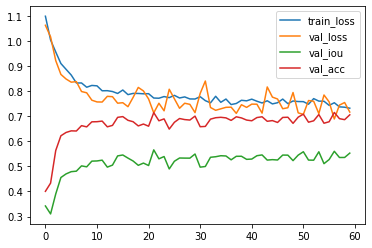

In [8]:
xs = range(EPOCH)
for key, data in records.items():
    plt.plot(xs, data, label=key)
plt.legend()

(128, 128, 3)


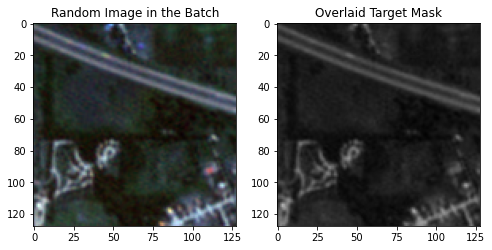

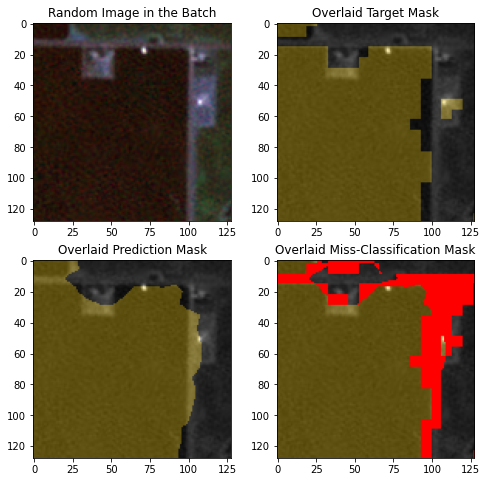

In [10]:
x, y = next(iter(train_loader))
y_pred = fcn(x.to(device))["out"].argmax(axis=1)
visualize_sample(x, y)
visualize_pred(x, y_pred, y)